<a href="https://colab.research.google.com/github/rennyatwork/CegepSteFoy_ReinfLearn_Work/blob/main/TP01/taxi_qlearning_and_mc_v02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 10.6 MB/s eta 0:00:00


## Imports

In [3]:
## Imports
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import display, clear_output
import time
from collections import defaultdict

## Constants

In [4]:
## Constants

RENDER_RGB = 'rgb_array'
RENDER_ANSI = 'ansi'

GAME_TAXI = 'Taxi-v3'

EPSILON_START = 1.0  # Initial exploration rate
EPSILON_DECAY = 0.995  # Decay rate for exploration
EPSILON_MIN = 0.1  # Minimum exploration rate
GAMMA = 0.9 # discount factor
EPISODES = 10000 #nb of episodes to run

In [5]:
## create env (rgb or ansi)

def create_env(pGame=GAME_TAXI, pRenderMode=RENDER_RGB, pPrint=False):
    if pPrint:
        print('[create_env] Creating environment...')
    try:
        env = gym.make(pGame, render_mode=pRenderMode)
        if pPrint:
            print('[create_env] Environment created successfully!')
        return env
    except Exception as e:
        print('[create_env] Error creating environment:', e)

## Functions to decode state (0-499), printing and plotting

In [6]:
## transform passenger and destination into (row, col)
def passenger_to_coordinates(location):
    if location == 0: return (0, 0)
    elif location == 1: return (0, 4)
    elif location == 2: return (4, 0)
    elif location == 3: return (4, 3)
    elif location == 4: return (4, 4)
    elif location == 5: return (-1, -1)  # Special case for inside the taxi
    else: raise ValueError("Invalid location")

def destination_to_coordinates(destination):
    if destination == 0: return (0, 0)
    elif destination == 1: return (0, 4)
    elif destination == 2: return (4, 0)
    elif destination == 3: return (4, 4)
    else: raise ValueError("Invalid destination")

def decode_state(pState, pPrint=False):
    # Taxi position
    taxi_row = pState // (5 * 5 * 4)  # 5 rows * 5 cols * 4 destinations (passenger_loc is 5 or less)
    pState %= 5 * 5 * 4

    taxi_col = pState // (5 * 4)  # 5 cols * 4 destinations
    pState %= 5 * 4

    # Passenger location
    passenger_loc = pState // 4  # passenger location is 0-5
    if passenger_loc == 5:
        passenger_loc = -1  # -1 represents the passenger is in the taxi

    # Destination
    destination = pState % 4  # destination is 0-3

    if pPrint:
        print(f'taxi position: {(taxi_row, taxi_col)}')
        print(f'passenger: {passenger_to_coordinates(passenger_loc)}')
        print(f'destination: {destination_to_coordinates(destination)}')


    return taxi_row, taxi_col, passenger_loc, destination

def plot_reward_evolution(rewards
                          , pXLabel = 'Episode'
                          , pYLabel = 'Reward'
                          , pTitle='Reward Evolution during Training'):
  """Plots the evolution of rewards over episodes.

  Args:
    rewards: A list of rewards obtained during training.
  """
  plt.clf() #clear cell
  plt.plot(rewards)
  plt.xlabel(pXLabel)
  plt.ylabel(pYLabel)
  plt.title(pTitle)

  # Calculate tick positions for 10 evenly spaced labels
  num_ticks = 10
  x_min = 0  # Assume x-axis starts at 0
  x_max = len(rewards) - 1  # Assume x-axis ends at the last data point
  tick_positions = np.linspace(x_min, x_max, num_ticks, dtype=int)

   # Set x-axis ticks and labels
  plt.xticks(tick_positions, tick_positions)  # Set both positions and labels


  plt.show()

  ## only used for rgb (graphical) rendering
def display_rgb(pEnv=create_env(), pPrintMultipleFrames=False):
    print('----------------')
    print('[display_rgb]')
    print('----------------')
    if pEnv.render_mode == RENDER_RGB:
        # Capture the frame for rendering
        frame = env.render()

        # Display the frame in Jupyter
        plt.imshow(frame)
        plt.axis('off')
        display(plt.gcf())
        if pPrintMultipleFrames:
            clear_output(wait=True)  # Clears the output for each frame
        time.sleep(0.1)  # Adjust for slower or faster playback

## plot all frames, one after the other
def plot_frames(frames, columns=4, pArrDecode=[]):
    rows = (len(frames) + columns - 1) // columns  # Calculate rows needed
    fig, axes = plt.subplots(rows, columns, figsize=(columns * 5, rows * 5))
    fig.tight_layout(pad=0.2)

    for i, frame in enumerate(frames):
        row, col = divmod(i, columns)
        ax = axes[row, col] if rows > 1 else axes[col]
        ax.imshow(frame)
        ax.axis('off')

        #if len(pArrDecode) > 0:
        #    taxi_row, taxi_col, passenger_loc, destination = pArrDecode[i]



    # Hide any unused subplots
    for j in range(i + 1, rows * columns):
        row, col = divmod(j, columns)
        ax = axes[row, col] if rows > 1 else axes[col]
        ax.axis('off')

    plt.show()

## Common functions to Q-learning and Monte Carlo

In [7]:
def create_q_table(env):
  """Creates a Q-table with all values initialized to 0.

  Args:
    env: The Gymnasium environment.

  Returns:
    A NumPy array representing the Q-table.
  """
  return np.zeros([env.observation_space.n, env.action_space.n])



def get_policy(q_table, state, epsilon):
  """Selects an action using the epsilon-greedy policy.

  Args:
    q_table: The Q-table containing learned values.
    state: The current state of the environment.
    epsilon: The exploration rate.

  Returns:
    The action selected by the policy.
  """
  if np.random.uniform(0, 1) < epsilon:
    action = env.action_space.sample()  # Explore action space
  else:
    action = np.argmax(q_table[state])  # Exploit learned values
  return action

# Q-learning

In [8]:


def train_q_learning(env
                     , q_table
                     , alpha=0.1
                     , gamma=GAMMA
                     , epsilon=EPSILON_START
                     , episodes=EPISODES
                     , pPrint=False
                     ):
  """Trains the Q-learning agent.

  Args:
    env: The Gymnasium environment.
    q_table: The Q-table to update.
    alpha: The learning rate.
    gamma: The discount factor.
    epsilon: The exploration rate.
    episodes: The number of training episodes.

    Returns:
    A tuple containing the trained Q-table and the list of rewards per episode.
  """

  start_time = time.time()

  rewards = []

  # List to store rewards per episode
  all_rewards_per_episode = []

  # Example decay rate
  epsilon_decay = EPSILON_DECAY


  for i in range(1, episodes + 1):
    state = env.reset()[0]
    epochs, penalties, reward = 0, 0, 0
    done = False


    while not done:

      action = get_policy(q_table, state, epsilon)

      # Decay epsilon over time:
      epsilon *= epsilon_decay
      epsilon = max(epsilon, EPSILON_MIN) # set the min epsilon

      ## step
      next_state, reward, done, truncated, info = env.step(action)


      old_value = q_table[state, action]

      ## q-learn selects the MAX next value
      next_max = np.max(q_table[next_state])

      ## 'learning' (update q_table)
      new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)

      ## update theq-table
      q_table[state, action] = new_value

      # reward -10 = leaving passenger somewhere else than destination
      if reward == -10:
        penalties += 1

      state = next_state
      epochs += 1

      rewards.append(reward)



    if pPrint:
      print("****************************************************")
      print(f"Episode: {i}")
      print(f"Timesteps taken: {epochs}")
      print(f"Penalties incurred: {penalties}")


    all_rewards_per_episode.append(np.mean(rewards)) # Calculating avg. reward per episode

    ten_pct_print = int(episodes/10)

    if i % (ten_pct_print) == 0:
      #print(f"Episode: {i}")
      avg_reward_last_100 = np.mean(all_rewards_per_episode[-ten_pct_print:]) # Calculating avg. reward for the last 100 episodes
      print(f"Episode: {i}, Average reward (last {ten_pct_print} episodes): {avg_reward_last_100}, current epsilon: {epsilon}")


    #if i % 1000 == 0:
     # plot_reward_evolution(rewards)

  elapsed_time = time.time() - start_time
  print(f"Training finished in {elapsed_time} secs.\n")
  return q_table, all_rewards_per_episode  # Return the Q-table and reward history




def evaluate_agent_ql(env
                   , q_table
                   , episodes=100
                   , pPrint=False
                   , pPlotGame=False
                   , pPlotGraphs=False
                   , pDecodeState=False):
  """Evaluates the trained agent.

  Args:
    env: The Gymnasium environment.
    q_table: The trained Q-table.
    episodes: The number of evaluation episodes.

  Returns:
    The average reward over the evaluation episodes.
  """

  if pPrint:
      print('Evaluating agent...')

  arr_avg_rewards = []
  arr_total_rewards = []
  arr_total_steps = []
  arr_penalties = []

  ## to print all at once
  arr_frames=[]

  ## to print positions
  arr_decode = []

  total_rewards = 0
  for ep in range(episodes):
    state = env.reset()[0]
    done = False
    episode_reward = 0

    steps_so_far = 0
    penalties = 0

    ## render game image
    if pPlotGame:
      ##display_rgb(env, pPrintMultipleFrames=True)
      arr_frames.append(env.render())

    ## print taxi, passenger and destination coords
    if pDecodeState:
      #decode_state(state, pPrint=True)
      arr_decode.append(decode_state(state, pPrint=False))

    while not done :
      action = np.argmax(q_table[state])

      ## step
      state, reward, done, truncated, info = env.step(action)

      ## render game image
      if pPlotGame:
        ## display_rgb(env, pPrintMultipleFrames=True)
        arr_frames.append(env.render())

      ## print taxi, passenger and destination coords
      if pDecodeState:
        #decode_state(state, pPrint=True)
        arr_decode.append(decode_state(state, pPrint=False))

      steps_so_far +=1

      if steps_so_far>30:
        print(f'Too many steps {steps_so_far} Bye !!!')
        done = True

      episode_reward += reward

      if reward == -10:
        penalties += 1
        if penalties >2:
          print(f'Too many wrong actions {penalties}. Bye !!!')
          done = True

      reward_per_step = episode_reward / steps_so_far


      if (pPrint and (steps_so_far % 50) ==0):
        print(f'steps_so_far: {steps_so_far}')
        print(f'Reward/step in episode [{ep}]: {reward_per_step}')

    total_rewards += episode_reward

    if pPrint:
      print(f"Episode [{ep}] [reward]: {episode_reward} - [reward/step]: {reward_per_step} - [penalties]: {penalties} - [total_steps]: {steps_so_far}")


    arr_total_steps.append(steps_so_far)
    arr_penalties.append(penalties)
    arr_avg_rewards.append(reward_per_step)
    arr_total_rewards.append(episode_reward)

  print(f"Results after {episodes} episodes:")
  print(f'len(arr_avg_rewards): {len(arr_avg_rewards)} ')
  print(f'len(arr_total_rewards): {len(arr_total_rewards)} ')
  print(f'len(arr_total_steps): {len(arr_total_steps)} ')
  print(f'len(arr_penalties): {len(arr_penalties)} ')

  ## render game image
  if pPlotGame:
    plot_frames(arr_frames)

  if pPlotGraphs:
    plot_reward_evolution(arr_avg_rewards
                          , pYLabel='Average Reward'
                          , pTitle='Average Reward evolution')
    plot_reward_evolution(arr_total_rewards
                          , pYLabel='Total Rewards'
                          , pTitle='Total Rewards evolution')
    plot_reward_evolution(arr_total_steps
                          , pYLabel='Total Steps'
                          , pTitle='Total Steps evolution')
    plot_reward_evolution(arr_penalties
                          , pYLabel='Penalties'
                          , pTitle='Penalties evolution')

  return total_rewards / episodes



### One Long Training

In [9]:
# Main execution
env = create_env(pGame=GAME_TAXI, pRenderMode=RENDER_RGB, pPrint=True)
q_table = create_q_table(env)


# Train with different parameters and store results
q_table1, rewards1 = train_q_learning(env, create_q_table(env), episodes=15000)



[create_env] Creating environment...
[create_env] Environment created successfully!
Episode: 1500, Average reward (last 1500 episodes): -1.2995186601356035, current epsilon: 0.1
Episode: 3000, Average reward (last 1500 episodes): -0.9968590600561383, current epsilon: 0.1
Episode: 4500, Average reward (last 1500 episodes): -0.806532027225499, current epsilon: 0.1
Episode: 6000, Average reward (last 1500 episodes): -0.6692835577472572, current epsilon: 0.1
Episode: 7500, Average reward (last 1500 episodes): -0.5665431672982711, current epsilon: 0.1
Episode: 9000, Average reward (last 1500 episodes): -0.4870551773481084, current epsilon: 0.1
Episode: 10500, Average reward (last 1500 episodes): -0.42408897088416386, current epsilon: 0.1
Episode: 12000, Average reward (last 1500 episodes): -0.37329143392955577, current epsilon: 0.1
Episode: 13500, Average reward (last 1500 episodes): -0.3286504440984541, current epsilon: 0.1
Episode: 15000, Average reward (last 1500 episodes): -0.2911727969

In [10]:
## q_table 1
average_reward = evaluate_agent_ql(env
                                , q_table1
                                , episodes=100
                                ,  pPrint=True
                                )

print(f"Average reward: {average_reward}")



Evaluating agent...
Episode [0] [reward]: 8 - [reward/step]: 0.6153846153846154 - [penalties]: 0 - [total_steps]: 13
Episode [1] [reward]: 10 - [reward/step]: 0.9090909090909091 - [penalties]: 0 - [total_steps]: 11
Episode [2] [reward]: 3 - [reward/step]: 0.16666666666666666 - [penalties]: 0 - [total_steps]: 18
Episode [3] [reward]: 11 - [reward/step]: 1.1 - [penalties]: 0 - [total_steps]: 10
Episode [4] [reward]: 8 - [reward/step]: 0.6153846153846154 - [penalties]: 0 - [total_steps]: 13
Episode [5] [reward]: 8 - [reward/step]: 0.6153846153846154 - [penalties]: 0 - [total_steps]: 13
Episode [6] [reward]: 9 - [reward/step]: 0.75 - [penalties]: 0 - [total_steps]: 12
Episode [7] [reward]: 9 - [reward/step]: 0.75 - [penalties]: 0 - [total_steps]: 12
Episode [8] [reward]: 4 - [reward/step]: 0.23529411764705882 - [penalties]: 0 - [total_steps]: 17
Episode [9] [reward]: 6 - [reward/step]: 0.4 - [penalties]: 0 - [total_steps]: 15
Episode [10] [reward]: 7 - [reward/step]: 0.5 - [penalties]: 0 -

Results after 1 episodes:
len(arr_avg_rewards): 1 
len(arr_total_rewards): 1 
len(arr_total_steps): 1 
len(arr_penalties): 1 


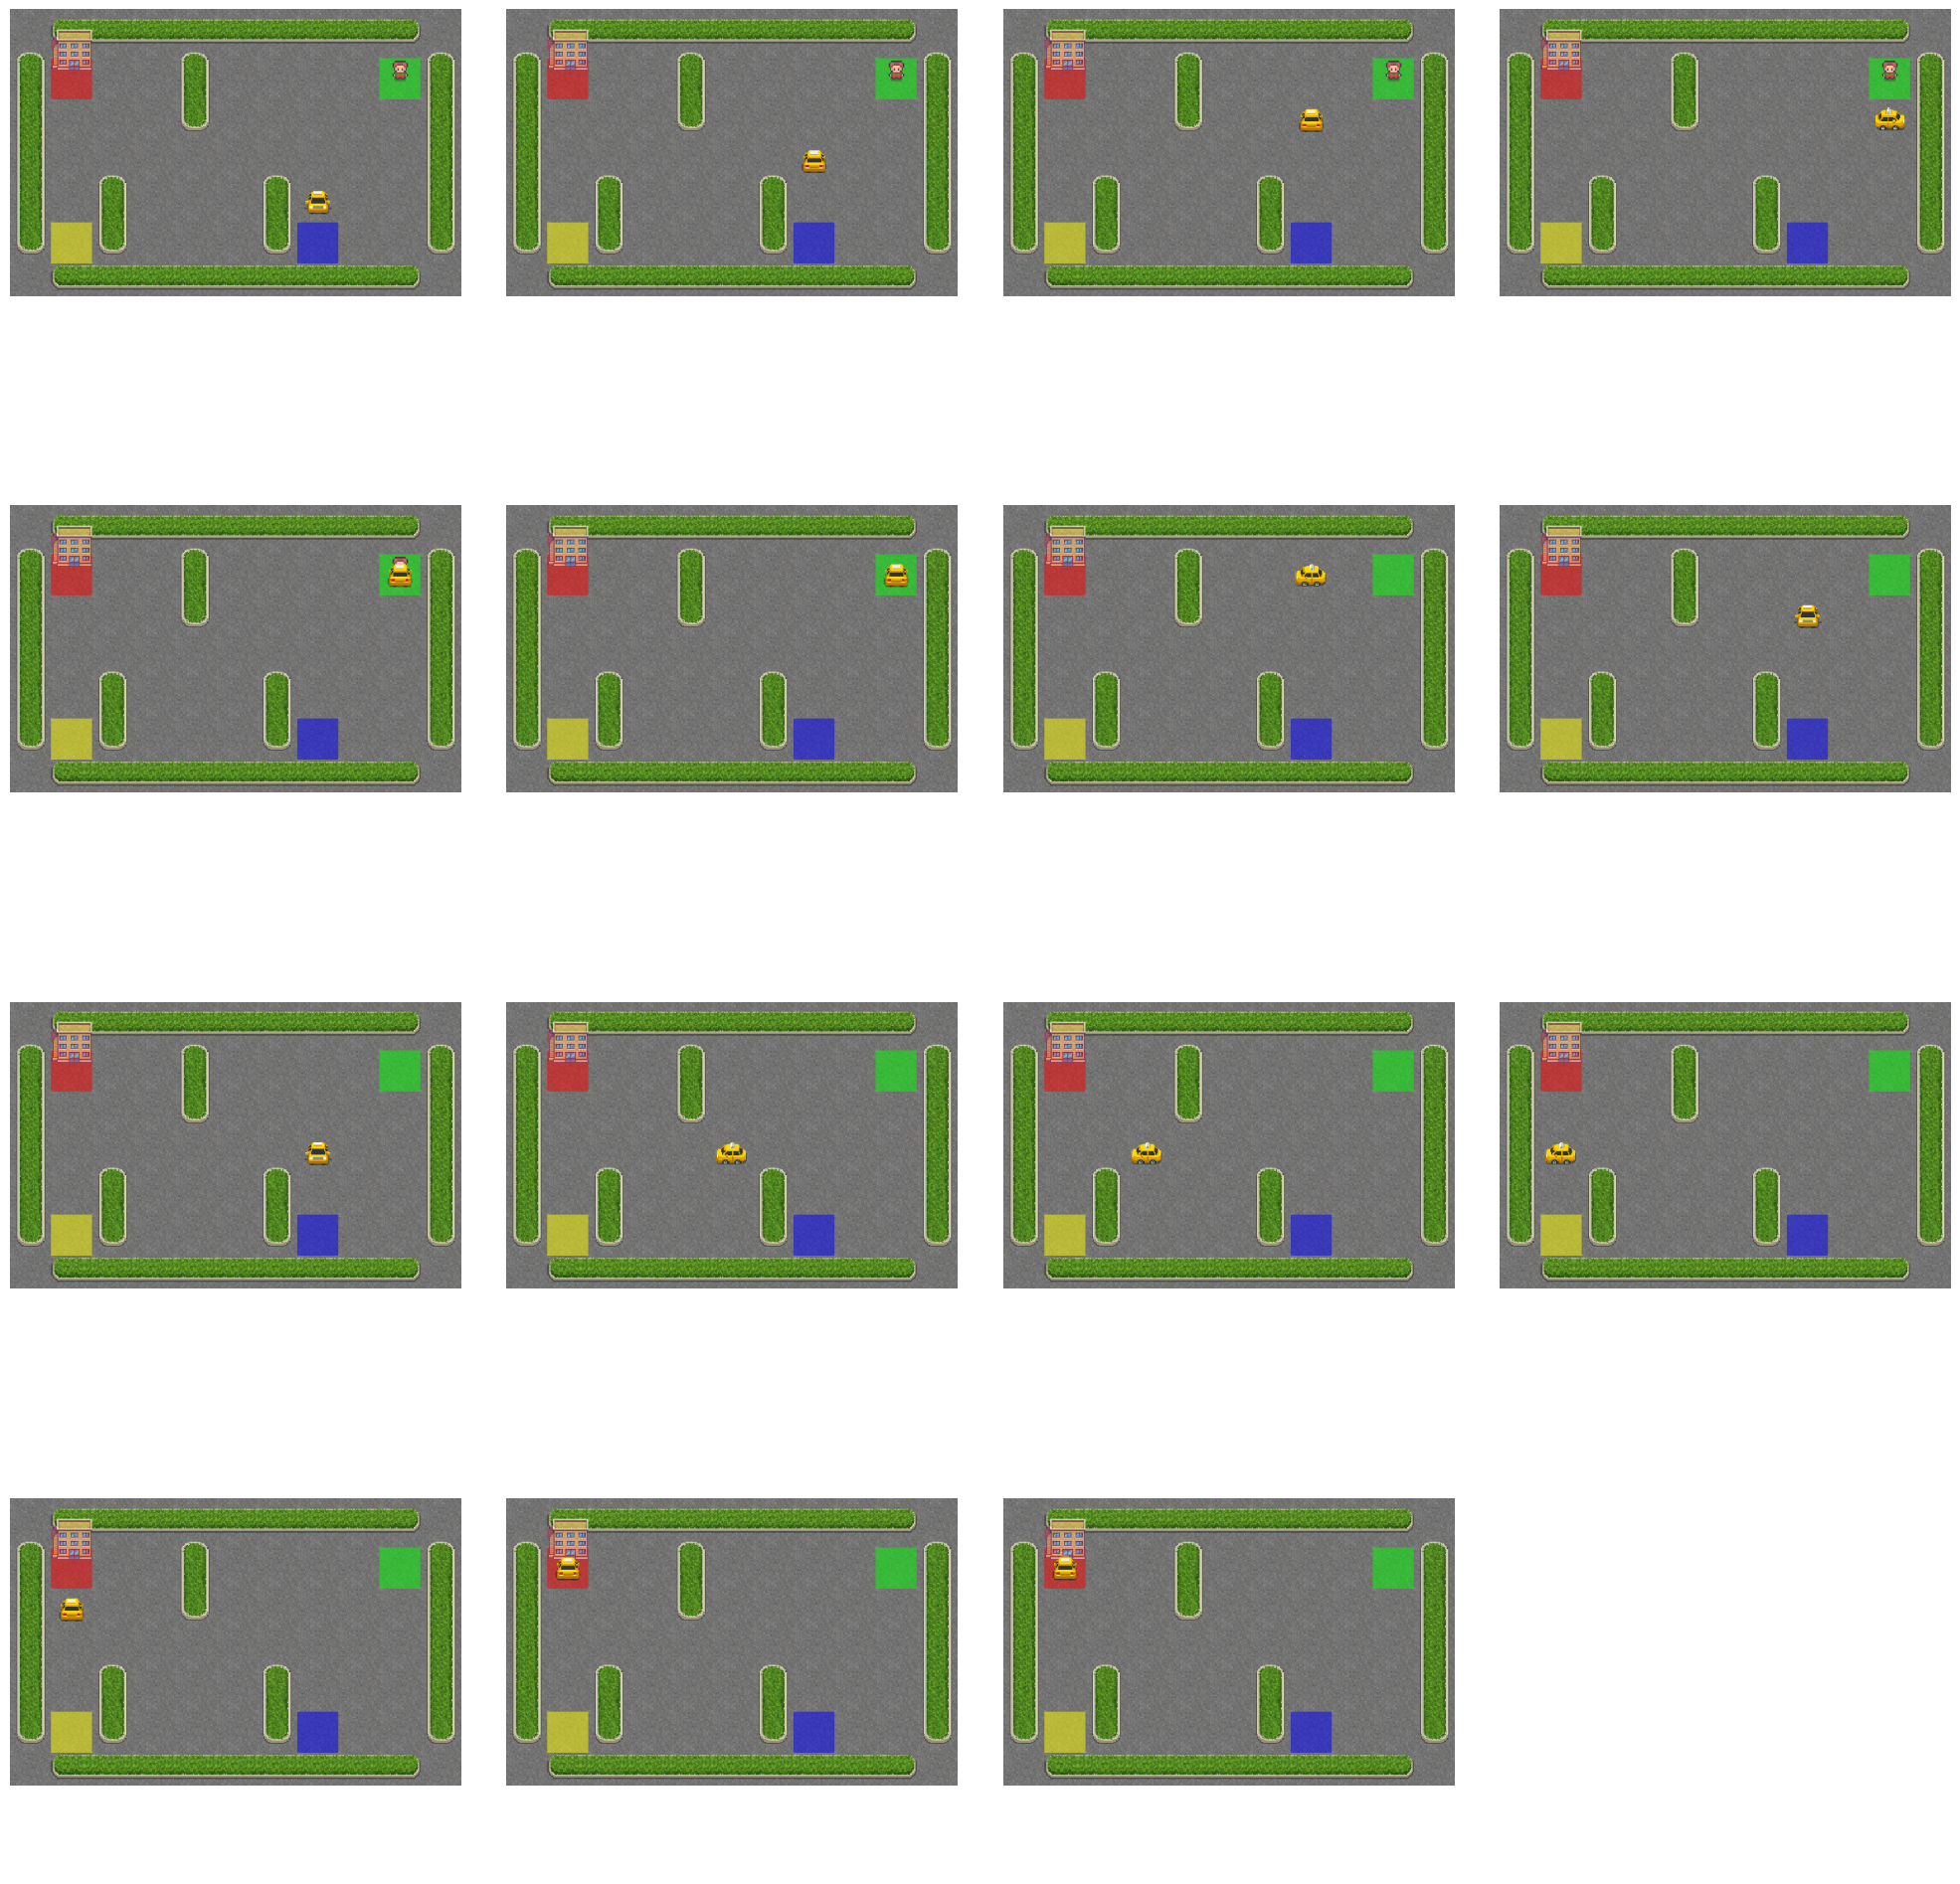

In [11]:
## plot the game
average_reward = evaluate_agent_ql(env
                                , q_table1
                                , episodes=1
                                ,  pPrint=False
                                , pPlotGame=True)
env.close()

### Combining trainings

In [53]:
# Main execution
env = create_env(pGame=GAME_TAXI, pRenderMode=RENDER_RGB, pPrint=True)
q_table = create_q_table(env)


# Train with different parameters and store results
q_table1_3, rewards1 = train_q_learning(env, create_q_table(env), episodes=5000)
q_table2_3, rewards2 = train_q_learning(env, q_table1_3, episodes=5000)
q_table3_3, rewards2 = train_q_learning(env, q_table2_3, episodes=5000)

# Now you have q_table1, q_table2, rewards1, and rewards2 for comparison


[create_env] Creating environment...
[create_env] Environment created successfully!
Episode: 500, Average reward (last 500 episodes): -1.462293567683403, current epsilon: 0.1
Episode: 1000, Average reward (last 500 episodes): -1.2776519428731425, current epsilon: 0.1
Episode: 1500, Average reward (last 500 episodes): -1.1717541462784142, current epsilon: 0.1
Episode: 2000, Average reward (last 500 episodes): -1.0787460222356609, current epsilon: 0.1
Episode: 2500, Average reward (last 500 episodes): -0.9973781830105377, current epsilon: 0.1
Episode: 3000, Average reward (last 500 episodes): -0.9259536615617526, current epsilon: 0.1
Episode: 3500, Average reward (last 500 episodes): -0.863612903949307, current epsilon: 0.1
Episode: 4000, Average reward (last 500 episodes): -0.8064342749663648, current epsilon: 0.1
Episode: 4500, Average reward (last 500 episodes): -0.7548549614502876, current epsilon: 0.1
Episode: 5000, Average reward (last 500 episodes): -0.7093085598032222, current ep

In [54]:
## q_table 3 of 3
average_reward = evaluate_agent_ql(env
                                , q_table3_3
                                , episodes=50
                                ,  pPrint=True)

print(f"Average reward: {average_reward}")

Evaluating agent...
Episode [0] [reward]: 7 - [reward/step]: 0.5 - [penalties]: 0 - [total_steps]: 14
Episode [1] [reward]: 7 - [reward/step]: 0.5 - [penalties]: 0 - [total_steps]: 14
Episode [2] [reward]: 7 - [reward/step]: 0.5 - [penalties]: 0 - [total_steps]: 14
Episode [3] [reward]: 11 - [reward/step]: 1.1 - [penalties]: 0 - [total_steps]: 10
Episode [4] [reward]: 11 - [reward/step]: 1.1 - [penalties]: 0 - [total_steps]: 10
Episode [5] [reward]: 7 - [reward/step]: 0.5 - [penalties]: 0 - [total_steps]: 14
Episode [6] [reward]: 5 - [reward/step]: 0.3125 - [penalties]: 0 - [total_steps]: 16
Episode [7] [reward]: 3 - [reward/step]: 0.16666666666666666 - [penalties]: 0 - [total_steps]: 18
Episode [8] [reward]: 5 - [reward/step]: 0.3125 - [penalties]: 0 - [total_steps]: 16
Episode [9] [reward]: 5 - [reward/step]: 0.3125 - [penalties]: 0 - [total_steps]: 16
Episode [10] [reward]: 12 - [reward/step]: 1.3333333333333333 - [penalties]: 0 - [total_steps]: 9
Episode [11] [reward]: 10 - [reward

Results after 1 episodes:
len(arr_avg_rewards): 1 
len(arr_total_rewards): 1 
len(arr_total_steps): 1 
len(arr_penalties): 1 


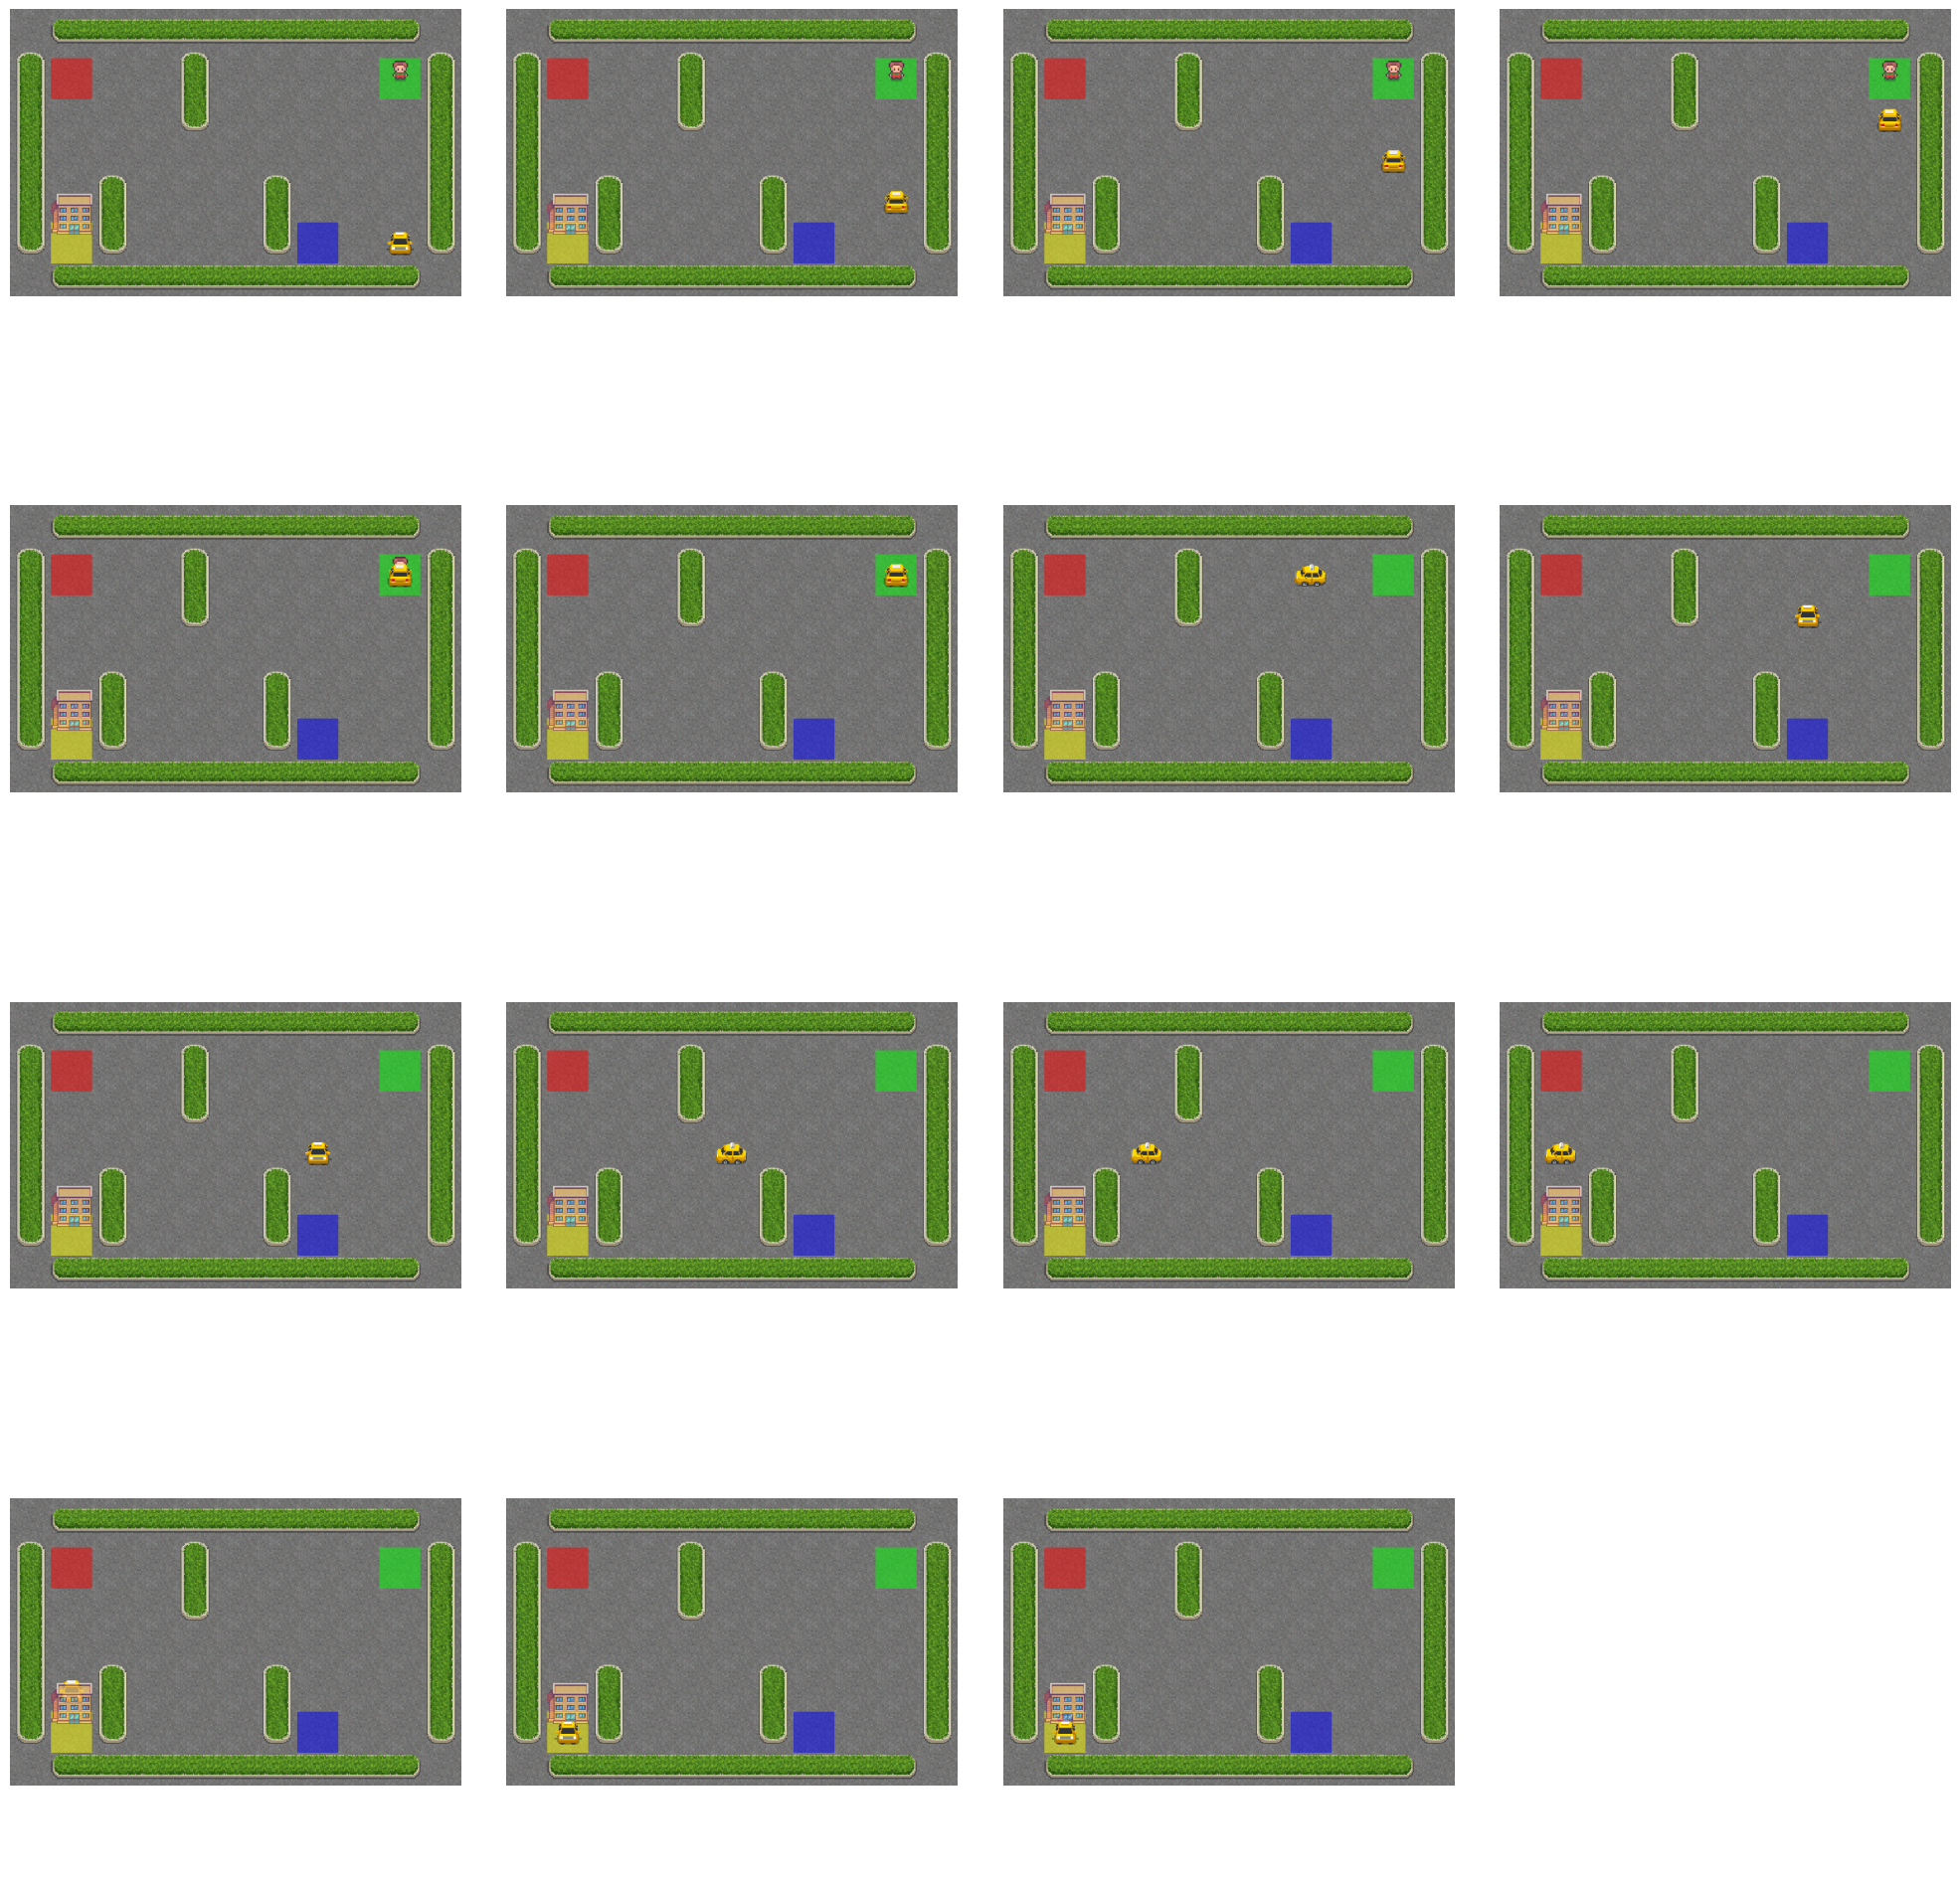

In [55]:
## plot the game
average_reward = evaluate_agent_ql(env
                                , q_table3_3
                                , episodes=1
                                ,  pPrint=False
                                , pPlotGame=True
                                , pDecodeState=True)
env.close()

### Short training

In [56]:
# Main execution
env = create_env(pGame=GAME_TAXI, pRenderMode=RENDER_RGB, pPrint=True)


# Train with different parameters and store results
q_table_short, rewards1 = train_q_learning(env, create_q_table(env), episodes=1000)


[create_env] Creating environment...
[create_env] Environment created successfully!
Episode: 100, Average reward (last 100 episodes): -1.6705277975455493, current epsilon: 0.1
Episode: 200, Average reward (last 100 episodes): -1.4703970282497714, current epsilon: 0.1
Episode: 300, Average reward (last 100 episodes): -1.4144761376190607, current epsilon: 0.1
Episode: 400, Average reward (last 100 episodes): -1.3780508934448081, current epsilon: 0.1
Episode: 500, Average reward (last 100 episodes): -1.3490964364237032, current epsilon: 0.1
Episode: 600, Average reward (last 100 episodes): -1.3215109267440435, current epsilon: 0.1
Episode: 700, Average reward (last 100 episodes): -1.297224197477763, current epsilon: 0.1
Episode: 800, Average reward (last 100 episodes): -1.2721028058971213, current epsilon: 0.1
Episode: 900, Average reward (last 100 episodes): -1.2486458148785635, current epsilon: 0.1
Episode: 1000, Average reward (last 100 episodes): -1.2265885347653283, current epsilon: 

In [57]:
## q_table 1
average_reward = evaluate_agent_ql(env
                                , q_table_short
                                , episodes=50
                                ,  pPrint=True)

print(f"Average reward: {average_reward}")

Evaluating agent...
Episode [0] [reward]: 11 - [reward/step]: 1.1 - [penalties]: 0 - [total_steps]: 10
Episode [1] [reward]: 11 - [reward/step]: 1.1 - [penalties]: 0 - [total_steps]: 10
Episode [2] [reward]: 8 - [reward/step]: 0.6153846153846154 - [penalties]: 0 - [total_steps]: 13
Too many steps 31 Bye !!!
Episode [3] [reward]: -31 - [reward/step]: -1.0 - [penalties]: 0 - [total_steps]: 31
Too many steps 31 Bye !!!
Episode [4] [reward]: -31 - [reward/step]: -1.0 - [penalties]: 0 - [total_steps]: 31
Episode [5] [reward]: 8 - [reward/step]: 0.6153846153846154 - [penalties]: 0 - [total_steps]: 13
Too many steps 31 Bye !!!
Episode [6] [reward]: -31 - [reward/step]: -1.0 - [penalties]: 0 - [total_steps]: 31
Too many steps 31 Bye !!!
Episode [7] [reward]: -31 - [reward/step]: -1.0 - [penalties]: 0 - [total_steps]: 31
Too many steps 31 Bye !!!
Episode [8] [reward]: -31 - [reward/step]: -1.0 - [penalties]: 0 - [total_steps]: 31
Too many steps 31 Bye !!!
Episode [9] [reward]: -31 - [reward/ste

Evaluating agent...
Too many steps 31 Bye !!!
Episode [0] [reward]: -31 - [reward/step]: -1.0 - [penalties]: 0 - [total_steps]: 31
Results after 1 episodes:
len(arr_avg_rewards): 1 
len(arr_total_rewards): 1 
len(arr_total_steps): 1 
len(arr_penalties): 1 


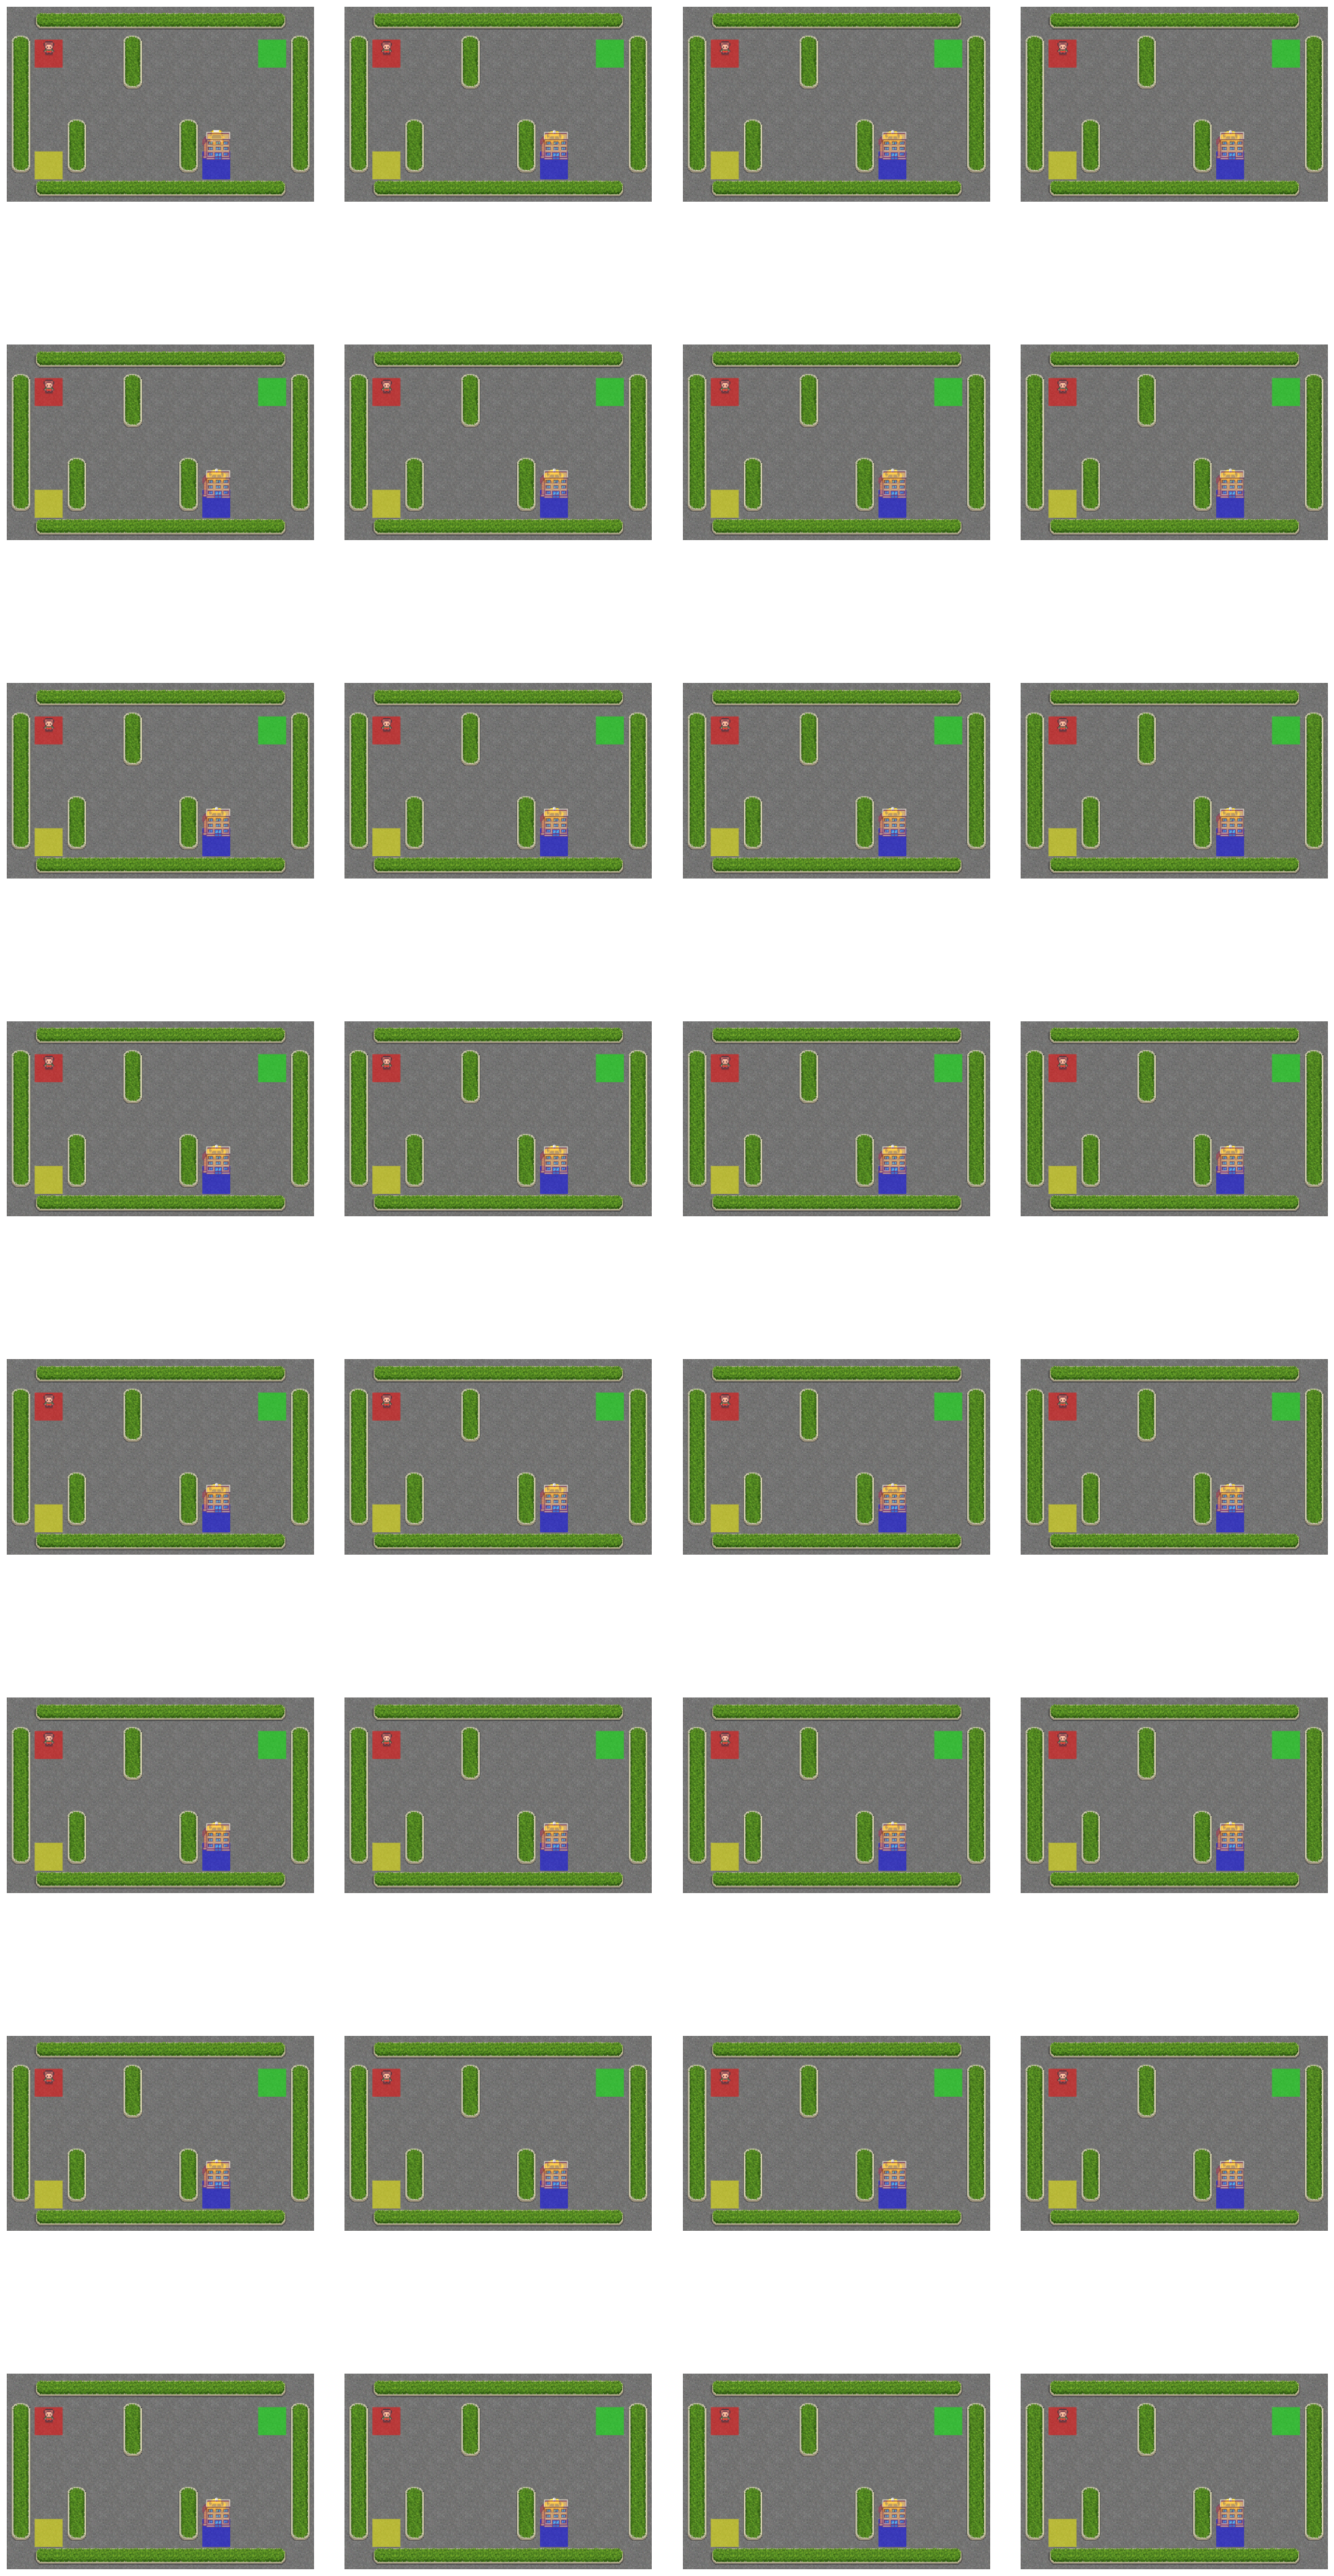

Average reward: -31.0


In [58]:
## q_table_short
average_reward = evaluate_agent_ql(env
                                , q_table_short
                                , episodes=1
                                ,  pPrint=True
                                , pPlotGame=True)

print(f"Average reward: {average_reward}")
env.close()

Not enough training example

# Monte Carlo

In [17]:


## env
env = create_env(pGame=GAME_TAXI, pRenderMode=RENDER_RGB, pPrint=True)

# Initialize Q-table with default values
Q_table = create_q_table(env)

def generate_episode(epsilon, pQTable = Q_table, pPrint=False):
    """Generate an episode and return the list of (state, action, reward)."""
    episode = []
    state, _ = env.reset()  # Reset returns an observation and info; take only the observation
    done = False

    iter_count=0
    while not done:
        action = get_policy(pQTable, state, epsilon)  # Use get_policy
        next_state, reward, done, truncated, _ = env.step(action)  # Adjusted for five values

        if pPrint and iter_count%1000==0:
          print(f"Next State: {next_state}, Reward: {reward}, Done: {done}")  # Debugging print
        episode.append((state, action, reward))
        state = next_state  # Keep state as is

    return episode

def update_Q_table(episode, pQTable=Q_table):
    """Update Q-table using the Monte Carlo method based on the episode generated."""
    G = 0  # Initialize return
    visited_state_actions = set()

    # Loop backwards through the episode
    for state, action, reward in reversed(episode):
        G = reward + GAMMA * G
        if (state, action) not in visited_state_actions:
            visited_state_actions.add((state, action))
            # Update Q-table with incremental average
            pQTable[state][action] += (G - pQTable[state][action]) / (1 + np.count_nonzero(pQTable[state]))


def train_monte_carlo_agent(pQTable = Q_table
                            , pEpisodes = EPISODES
                            , pEpsilon = EPSILON_START
                            , pEpsilonMin = EPSILON_MIN
                            , pEpsilonDecay = EPSILON_DECAY
                            , pPrint=False):
    """Train the agent using the Monte Carlo method."""
    epsilon = EPSILON_START
    start_time = time.time()


    for episode in range(pEpisodes):
        # Generate an episode and update Q-table
        episode_data = generate_episode(epsilon, pQTable, pPrint)
        update_Q_table(episode_data)

        # Decay epsilon after each episode
        epsilon = max(pEpsilonMin, pEpsilon * pEpsilonDecay)

        # Print progress and elapsed time every 100 episodes
        if int((episode + 1) % int(pEpisodes*0.1)) == 0:
            elapsed_time = time.time() - start_time
            print(f"Episode {episode + 1}/{pEpisodes} completed. Time elapsed: {elapsed_time:.2f} seconds")

    total_time = time.time() - start_time
    print(f"\nTraining completed in {total_time:.2f} seconds")

    # return pQTable, epsilon
    return pQTable


def evaluate_agent(pEnv, episodes=100,   pQTable=Q_table, pPrint = False):
    """Evaluate the agent's performance over a number of episodes."""
    total_rewards = 0

    step_count = 0
    penalties = 0

    env = pEnv
    start_time = time.time()

    for _ in range(episodes):
        state, _ = env.reset()  # Reset returns an observation and info; take only the observation
        done = False
        episode_reward = 0

        if pPrint:
          print('-------')
          print(f'iter: {_}')
          print(decode_state(pState=state, pPrint=True))

        if (step_count >29 or penalties >2):
          done=True
          print('Too many errors. BYE!!!')

        while not done:
            ## Use the greedy policy since we want to evaluate the learned Q-table
            #action = np.argmax(Q_table[state]) if state in Q_table else env.action_space.sample()
            action = get_policy(pQTable, state=state, epsilon = 0.1)
            next_state, reward, done, truncated, info = env.step(action)
            episode_reward += reward
            state = next_state  # Keep state as is
            step_count+=1

            if reward == -10:
              penalties +=1


        total_rewards += episode_reward

    avg_reward = total_rewards / episodes
    elapsed_time = time.time() - start_time
    print(f"\nEvaluation completed. Average reward over {episodes} episodes: {avg_reward:.2f}")
    print(f"Time elapsed for evaluation: {elapsed_time:.2f} seconds")




[create_env] Creating environment...
[create_env] Environment created successfully!


In [18]:
# Run training
env_mc_01 = create_env( pGame=GAME_TAXI, pRenderMode=RENDER_RGB, pPrint=True)

q_tab_mc = train_monte_carlo_agent(pEpisodes=50)



[create_env] Creating environment...
[create_env] Environment created successfully!
Episode 5/50 completed. Time elapsed: 0.22 seconds
Episode 10/50 completed. Time elapsed: 0.71 seconds
Episode 15/50 completed. Time elapsed: 1.16 seconds
Episode 20/50 completed. Time elapsed: 2.03 seconds
Episode 25/50 completed. Time elapsed: 2.25 seconds
Episode 30/50 completed. Time elapsed: 2.61 seconds
Episode 35/50 completed. Time elapsed: 3.30 seconds
Episode 40/50 completed. Time elapsed: 4.01 seconds
Episode 45/50 completed. Time elapsed: 5.61 seconds
Episode 50/50 completed. Time elapsed: 6.30 seconds

Training completed in 6.30 seconds


In [21]:
evaluate_agent(pEnv = env_mc_01, pQTable=q_tab_mc,   episodes=100, pPrint=True)
env_mc_01.close()

-------
iter: {'prob': 1.0, 'action_mask': array([1, 0, 0, 1, 0, 0], dtype=int8)}
taxi position: (0, 4)
passenger: (4, 0)
destination: (0, 4)
(0, 4, 2, 1)


KeyboardInterrupt: 

In [102]:
env_mc_01_15k = create_env( pGame=GAME_TAXI, pRenderMode=RENDER_RGB, pPrint=True)

q_tab_mc_15k = train_monte_carlo_agent(pEpisodes=15000)

[create_env] Creating environment...
[create_env] Environment created successfully!
Episode 1500/15000 completed. Time elapsed: 90.26 seconds
Episode 3000/15000 completed. Time elapsed: 181.99 seconds
Episode 4500/15000 completed. Time elapsed: 273.48 seconds
Episode 6000/15000 completed. Time elapsed: 361.86 seconds
Episode 7500/15000 completed. Time elapsed: 453.83 seconds
Episode 9000/15000 completed. Time elapsed: 542.51 seconds
Episode 10500/15000 completed. Time elapsed: 630.03 seconds
Episode 12000/15000 completed. Time elapsed: 720.45 seconds
Episode 13500/15000 completed. Time elapsed: 807.06 seconds
Episode 15000/15000 completed. Time elapsed: 897.20 seconds

Training completed in 897.20 seconds


In [107]:
evaluate_agent(pEnv = env_mc_01_15k, pQTable=q_tab_mc_15k,   episodes=100)


Evaluation completed. Average reward over 100 episodes: -10804.86
Time elapsed for evaluation: 7.03 seconds


In [111]:
q_tab_mc_15k

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [-32.96045736, -32.72716229, -32.02935379, -33.25547173,
        -34.47469138, -38.39931576],
       [-35.71015771, -28.91541678, -29.5336324 , -32.32571603,
        -30.15847707, -38.4752392 ],
       ...,
       [-37.21430658, -37.34506986, -36.93834814, -30.59067884,
        -40.62109872, -36.78383007],
       [-32.934117  , -38.42941226, -32.72276212, -31.64394995,
        -36.11994084, -39.57804148],
       [-19.35882117, -23.23599714, -17.60183251,   0.72333318,
        -28.78431563, -26.27131875]])

In [110]:
q_tab_mc_15k = train_monte_carlo_agent(pEpisodes=5000, pQTable=q_tab_mc_15k)

Episode 500/5000 completed. Time elapsed: 27.36 seconds
Episode 1000/5000 completed. Time elapsed: 57.03 seconds
Episode 1500/5000 completed. Time elapsed: 84.77 seconds
Episode 2000/5000 completed. Time elapsed: 113.54 seconds
Episode 2500/5000 completed. Time elapsed: 138.61 seconds
Episode 3000/5000 completed. Time elapsed: 168.29 seconds
Episode 3500/5000 completed. Time elapsed: 197.66 seconds
Episode 4000/5000 completed. Time elapsed: 227.31 seconds
Episode 4500/5000 completed. Time elapsed: 257.86 seconds
Episode 5000/5000 completed. Time elapsed: 292.18 seconds

Training completed in 292.18 seconds


In [112]:
evaluate_agent(pEnv = env_mc_01_15k, pQTable=q_tab_mc_15k,   episodes=100)


Evaluation completed. Average reward over 100 episodes: -10460.54
Time elapsed for evaluation: 6.94 seconds


In [93]:
# Run training
env_mc_02 = create_env( pGame=GAME_TAXI, pRenderMode=RENDER_RGB, pPrint=True)

q_tab_mc_01 = train_monte_carlo_agent(pEpisodes=100)
q_tab_mc_02 = train_monte_carlo_agent(pEpisodes=100, pQTable=q_tab_mc_01)
q_tab_mc_03 = train_monte_carlo_agent(pEpisodes=100, pQTable=q_tab_mc_02)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[create_env] Creating environment...
[create_env] Environment created successfully!
Episode 10/100 completed. Time elapsed: 0.68 seconds
Episode 20/100 completed. Time elapsed: 1.12 seconds
Episode 30/100 completed. Time elapsed: 1.51 seconds
Episode 40/100 completed. Time elapsed: 2.02 seconds
Episode 50/100 completed. Time elapsed: 2.87 seconds
Episode 60/100 completed. Time elapsed: 3.84 seconds
Episode 70/100 completed. Time elapsed: 4.53 seconds
Episode 80/100 completed. Time elapsed: 4.98 seconds
Episode 90/100 completed. Time elapsed: 5.45 seconds
Episode 100/100 completed. Time elapsed: 6.11 seconds

Training completed in 6.12 seconds
Episode 10/100 completed. Time elapsed: 0.31 seconds
Episode 20/100 completed. Time elapsed: 0.78 seconds
Episode 30/100 completed. Time elapsed: 1.38 seconds
Episode 40/100 completed. Time elapsed: 2.09 seconds
Episode 50/100 completed. Time elapsed: 2.72 seconds
Episode 60/100 completed. Time elapsed: 3.42 seconds
Episode 70/100 completed. Time 

In [94]:
# Evaluate the trained agent
evaluate_agent(pEnv = env_mc_02, pQTable=q_tab_mc_03,   episodes=100)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Evaluation completed. Average reward over 100 episodes: -10672.11
Time elapsed for evaluation: 7.05 seconds


In [ ]:
import numpy as np
import gym
import time

## Constants
RENDER_RGB = 'rgb_array'
RENDER_ANSI = 'ansi'
GAME_TAXI = 'Taxi-v3'
EPSILON_START = 1.0  # Initial exploration rate
EPSILON_DECAY = 0.995  # Decay rate for exploration
EPSILON_MIN = 0.1  # Minimum exploration rate
GAMMA = 0.9  # Discount factor
EPISODES = 10000  # Number of episodes to run

def create_env(pGame=GAME_TAXI, pRenderMode=RENDER_RGB, pPrint=False):
    if pPrint:
        print('[create_env] Creating environment...')
    try:
        env = gym.make(pGame, render_mode=pRenderMode)
        if pPrint:
            print('[create_env] Environment created successfully!')
        return env
    except Exception as e:
        print('[create_env] Error creating environment:', e)

def create_q_table(env):
    """Creates a Q-table with all values initialized to 0."""
    return np.zeros([env.observation_space.n, env.action_space.n])

# Initialize environment and Q-table
env = create_env(pGame=GAME_TAXI, pRenderMode=RENDER_RGB, pPrint=True)
Q_table = create_q_table(env)

def get_policy(q_table, state, epsilon):
    """Selects an action using the epsilon-greedy policy."""
    if np.random.rand() < epsilon:
        return env.action_space.sample()  # Explore
    return np.argmax(q_table[state])  # Exploit

def generate_episode(epsilon):
    """Generate an episode and return the list of (state, action, reward)."""
    episode = []
    state, _ = env.reset()  # Reset returns an observation and info; take only the observation
    done = False

    while not done:
        action = get_policy(Q_table, state, epsilon)  # Use get_policy
        next_state, reward, done, truncated, _ = env.step(action)  # Adjusted for five values
        print(f"Next State: {next_state}, Reward: {reward}, Done: {done}")  # Debugging print
        episode.append((state, action, reward))
        state = next_state  # Keep state as is

    return episode

def update_Q_table(episode):
    """Update Q-table using the Monte Carlo method based on the episode generated."""
    G = 0  # Initialize return
    visited_state_actions = set()

    # Loop backwards through the episode
    for state, action, reward in reversed(episode):
        G = reward + GAMMA * G
        if (state, action) not in visited_state_actions:
            visited_state_actions.add((state, action))
            # Update Q-table with incremental average
            Q_table[state][action] += (G - Q_table[state][action]) / (1 + np.count_nonzero(Q_table[state]))

def train_monte_carlo_agent():
    """Train the agent using the Monte Carlo method."""
    epsilon = EPSILON_START
    start_time = time.time()

    for episode in range(EPISODES):
        # Generate an episode and update Q-table
        episode_data = generate_episode(epsilon)
        update_Q_table(episode_data)

        # Decay epsilon after each episode
        epsilon = max(EPSILON_MIN, epsilon * EPSILON_DECAY)

        # Print progress and elapsed time every 100 episodes
        if (episode + 1) % 100 == 0:
            elapsed_time = time.time() - start_time
            print(f"Episode {episode + 1}/{EPISODES} completed. Time elapsed: {elapsed_time:.2f} seconds")

    total_time = time.time() - start_time
    print(f"\nTraining completed in {total_time:.2f} seconds")

def evaluate_agent(episodes=100):
    """Evaluate the agent's performance over a number of episodes."""
    total_rewards = 0
    start_time = time.time()

    for _ in range(episodes):
        state, _ = env.reset()  # Reset returns an observation and info; take only the observation
        done = False
        episode_reward = 0

        while not done:
            # Use the greedy policy since we want to evaluate the learned Q-table
            action = np.argmax(Q_table[state]) if state in Q_table else env.action_space.sample()
            next_state, reward, done, truncated, info = env.step(action)
            episode_reward += reward
            state = next_state  # Keep state as is

        total_rewards += episode_reward

    avg_reward = total_rewards / episodes
    elapsed_time = time.time() - start_time
    print(f"\nEvaluation completed. Average reward over {episodes} episodes: {avg_reward:.2f}")
    print(f"Time elapsed for evaluation: {elapsed_time:.2f} seconds")

# Run training
train_monte_carlo_agent()

# Evaluate the trained agent
evaluate_agent(episodes=100)
